# Testing low rank and sparse PFM

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as sci
from low_rank_pfm.src.low_rank import low_rank
from low_rank_pfm.src.hrf_matrix import HRFMatrix
from simulate import fMRIsim

## Debiasing function

In [2]:
def debiasing(x, y, beta, thr=1e-3):

    beta_out = np.zeros(beta.shape)
    fitts_out = np.zeros(y.shape)

    index_voxels = np.unique(np.where(abs(beta) > thr)[1])

    print('Debiasing results...')
    for voxidx in range(len(index_voxels)):
        index_events_opt = np.where(
            abs(beta[:, index_voxels[voxidx]]) > thr)[0]

        if index_events_opt.size != 0:
            X_events = x[:, index_events_opt]
            beta2save = np.zeros((beta.shape[0], 1))

            coef_LSfitdebias, _, _, _ = sci.linalg.lstsq(
                X_events, y[:, index_voxels[voxidx]], cond=None)
            beta2save[index_events_opt, 0] = coef_LSfitdebias

            beta_out[:, index_voxels[voxidx]] = beta2save.reshape(len(beta2save))
            fitts_out[:, index_voxels[voxidx]] = np.dot(X_events, coef_LSfitdebias)
        else:
            beta_out[:, index_voxels[voxidx]] = np.zeros((beta.shape[0], 1))
            fitts_out[:, index_voxels[voxidx]] = np.zeros((beta.shape[0], 1))

    print('Debiasing completed.')
    return(beta_out, fitts_out)

## Simulate data

In [3]:
# Initialize class
sim = fMRIsim()

# Set parameters
sim.nvoxels = 1000
sim.nevents = 4
sim.min_length = 1 # Minimun TR length of an event
sim.max_length = 5 # Maximum TR length of an event
sim.gap = 35 # Number of timepoints between events
sim.tr = 2
sim.dur = 600 # In seconds
sim.te = [35] # Must be a list
sim.db = 5
sim.ngroups = 5
sim.group = [20, 30, 15, 35, 900] # Must be a list

# Simulate timeseries
sim.simulate()


Groups: [20, 30, 15, 35, 900]
Group change idxs: [  0.  19.  49.  64.  99. 999.]
Finishing simulation of data...


In [4]:
data = sim.simulation
ground_truth = sim.bold
nscans = data.shape[0]
nvoxels = data.shape[1]
print(f'Data has {nscans} scans and {nvoxels} voxels')

Data has 300 scans and 1000 voxels


## Plot data without spikes and respiration

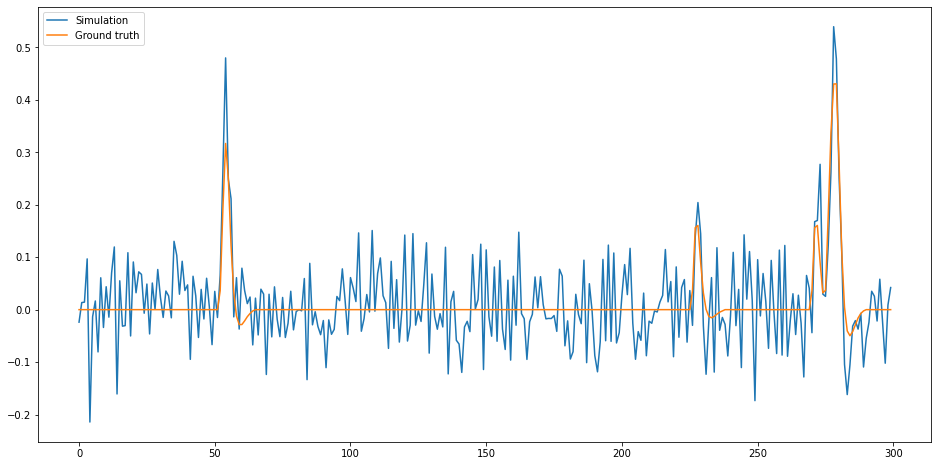

In [5]:
plt.figure(figsize=(16,8))
plt.plot(data[:, 0], label='Simulation')
plt.plot(ground_truth[:, 0], label='Ground truth')
plt.legend()

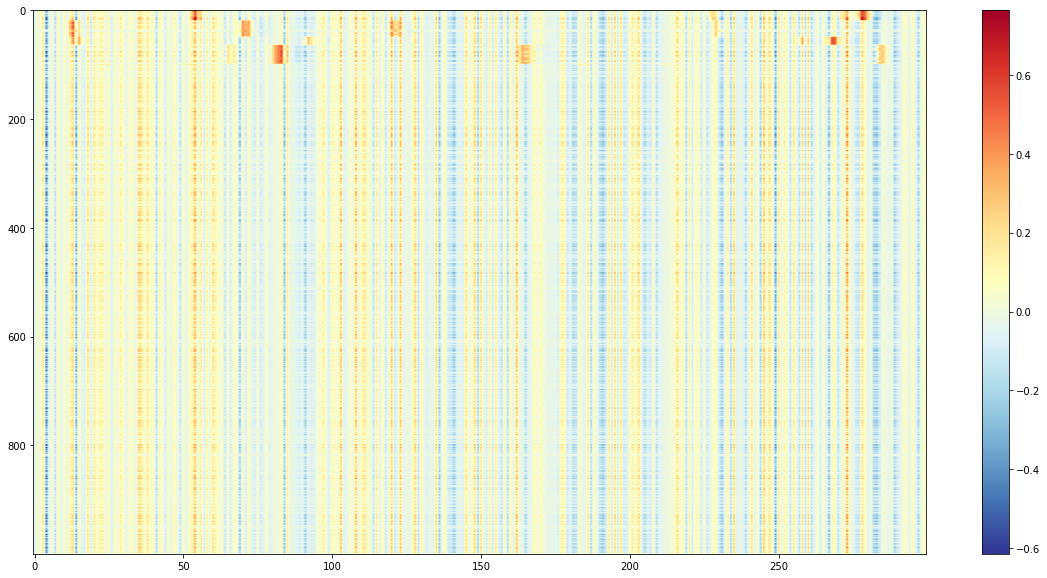

In [6]:
plt.figure(figsize=(20,10))
plt.imshow(data.T, cmap=cm.RdYlBu_r, aspect='auto')
plt.colorbar()

## Add respiration and spikes

In [7]:
t = np.linspace(0, nscans * sim.tr, nscans)
RRF = 0.6 * (t ** 2.1) * np.exp(-t/1.6) - 0.0023 * (t ** 3.54) * np.exp(-t/4.25)

RRF_mtx = RRF
for i in range(nscans-1):
    foo = np.append(np.zeros(i+1), RRF[0:(len(RRF)-i-1)])      
    RRF_mtx = np.column_stack((RRF_mtx, foo))

resp_spikes = np.zeros((nscans, 1))

##################################
# Add respiration components here:
resp_spikes[140] = 1
resp_spikes[170] = 1
##################################

resp_spikes_conv = np.dot(RRF_mtx, resp_spikes)
resp_spikes_conv = resp_spikes_conv/np.max(resp_spikes_conv)*np.max(data[:])*0.8

spikes_scale = np.random.rand(nvoxels)
spikes = np.dot(resp_spikes_conv, np.ones((1, nvoxels))) * spikes_scale

##################################
# Add spikes here:
spikes[200, :] = np.max(spikes)*np.random.rand(1, nvoxels)
##################################

data += spikes

## Plot data with spikes and respiration

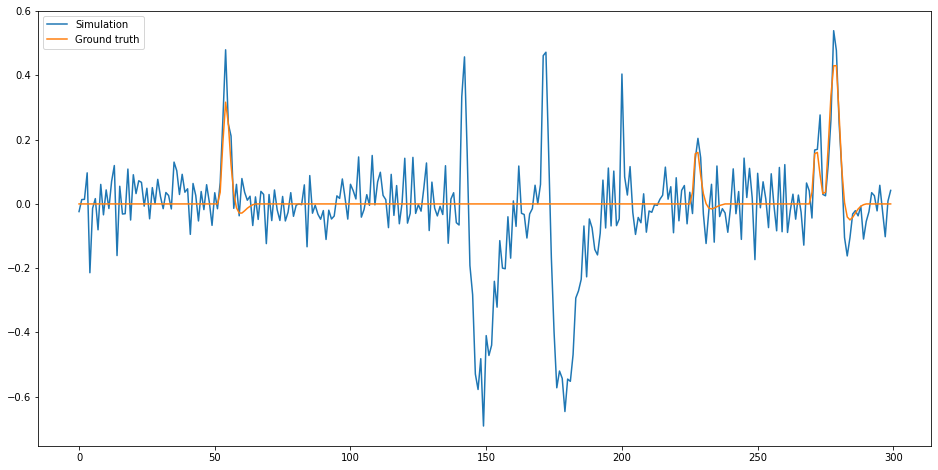

In [8]:
plt.figure(figsize=(16,8))
plt.plot(data[:, 0], label='Simulation')
plt.plot(ground_truth[:, 0], label='Ground truth')
plt.legend()

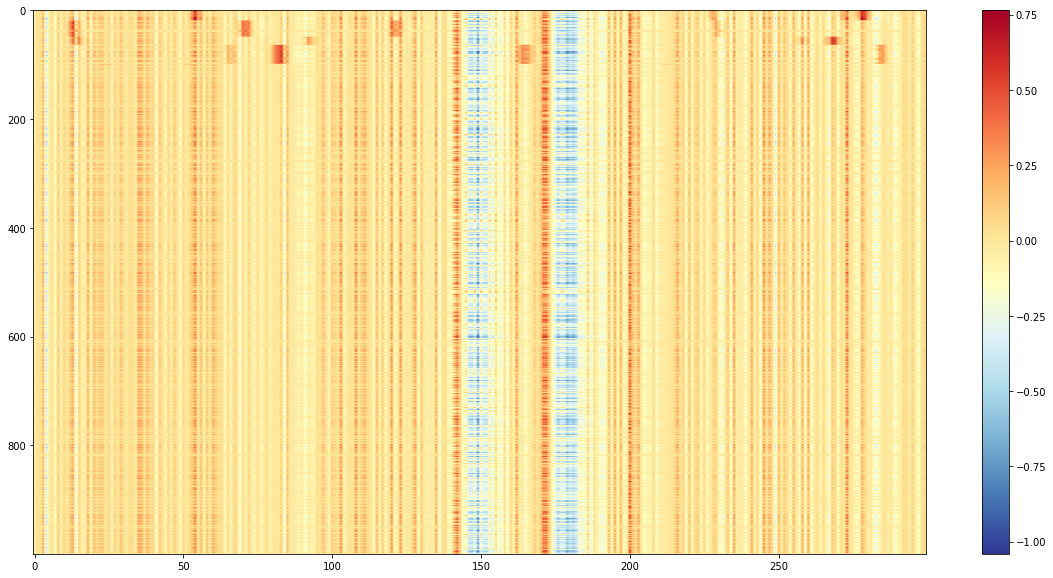

In [9]:
plt.figure(figsize=(20,10))
plt.imshow(data.T, cmap=cm.RdYlBu_r, aspect='auto')
plt.colorbar()

## Low rank and sparse PFM

In [10]:
%%capture
hrf_obj = HRFMatrix(TR=sim.tr, nscans=int(data.shape[0]), TE=sim.te, has_integrator=False)
hrf_norm = hrf_obj.generate_hrf().X_hrf_norm

L, S = low_rank(data=data, hrf=hrf_norm)

#### Thresholding at 1% seems to be the best option

In [11]:
S_deb, S_fitts = debiasing(x=hrf_norm, y=data, beta=S, thr=1e-1)

Debiasing results...
Debiasing completed.


## Plot results

Text(0.5, 1.0, 'Estimated fitts')

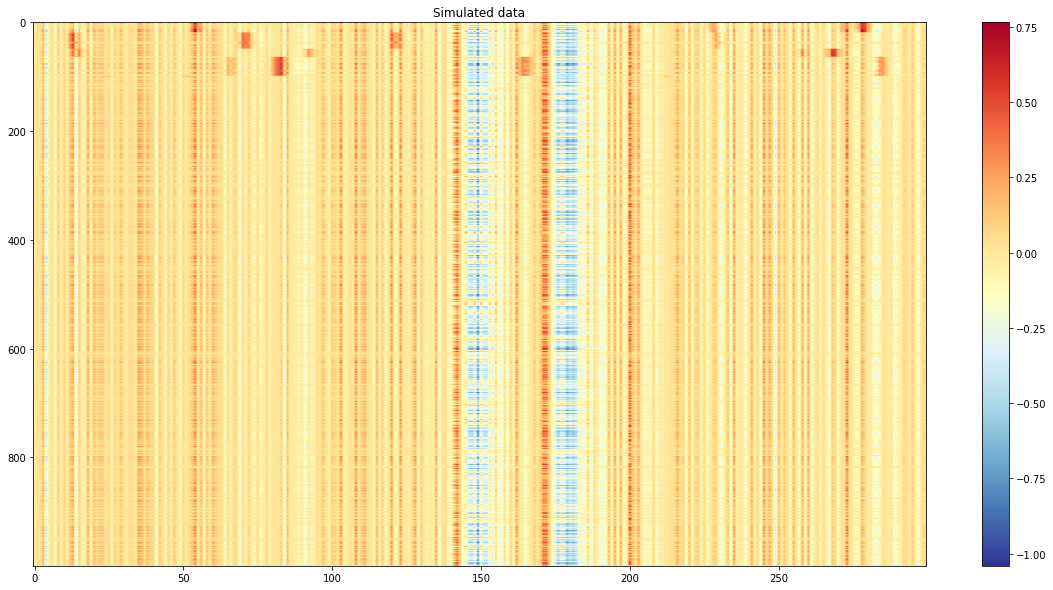

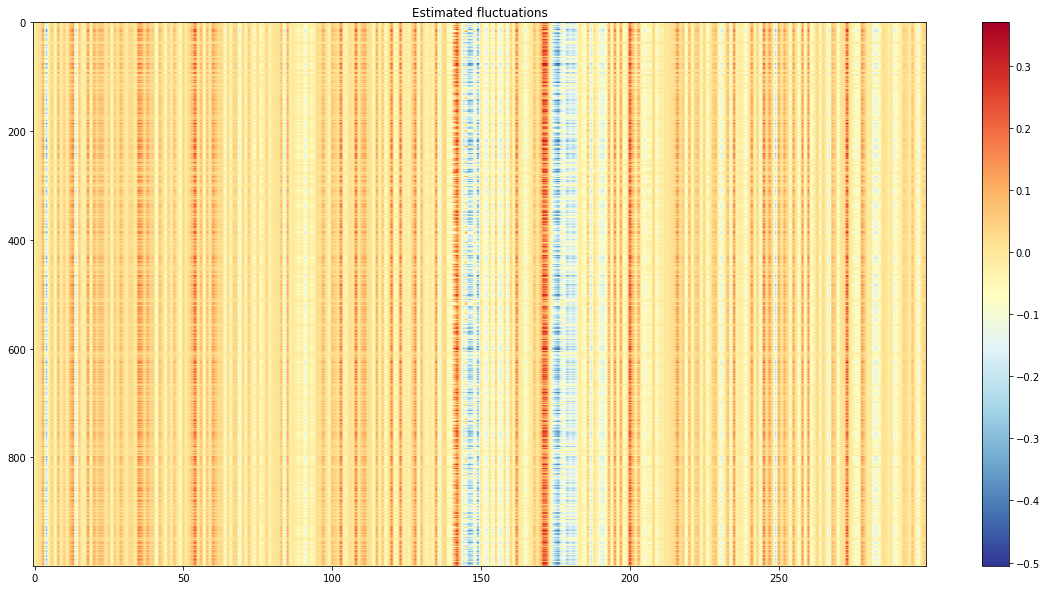

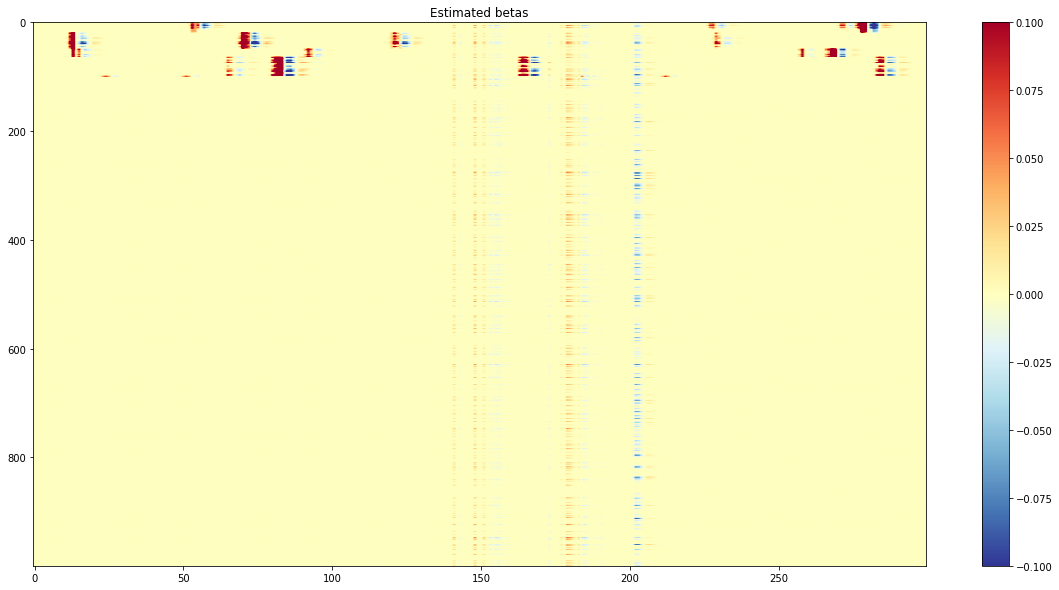

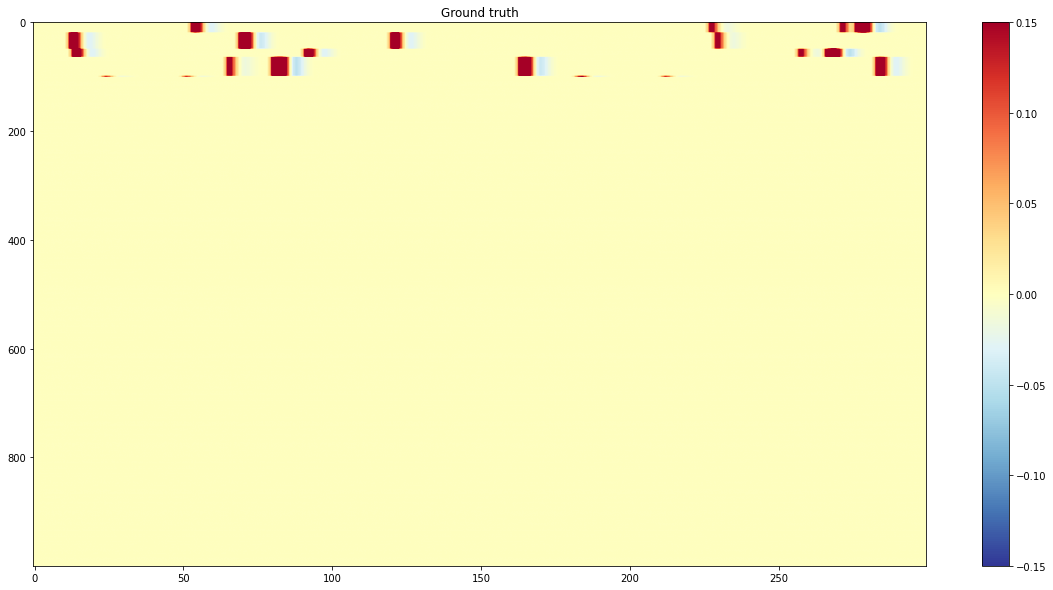

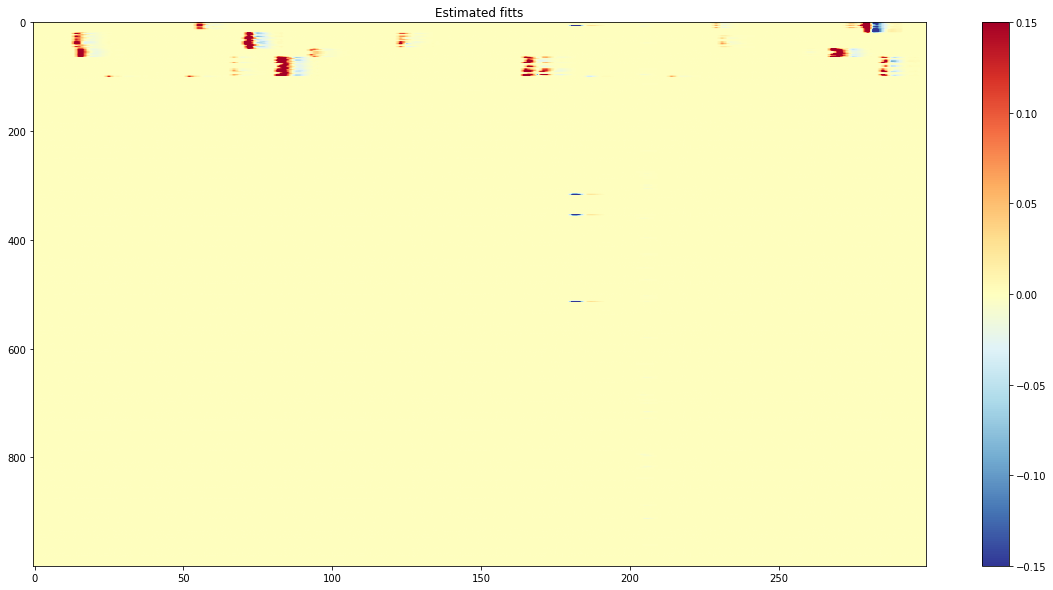

In [12]:
plt.figure(figsize=(20,10))
plt.imshow(data.T, cmap=cm.RdYlBu_r, aspect='auto')
plt.colorbar()
plt.title('Simulated data')

plt.figure(figsize=(20,10))
plt.imshow(L.T, cmap=cm.RdYlBu_r, aspect='auto')
plt.colorbar()
plt.title('Estimated fluctuations')

plt.figure(figsize=(20,10))
plt.imshow(S.T, cmap=cm.RdYlBu_r, aspect='auto', vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.title('Estimated betas')

plt.figure(figsize=(20,10))
plt.imshow(ground_truth.T, cmap=cm.RdYlBu_r, aspect='auto', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.title('Ground truth')

plt.figure(figsize=(20,10))
plt.imshow(S_fitts.T, cmap=cm.RdYlBu_r, aspect='auto', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.title('Estimated fitts')

## Testing with 200 voxels (100 voxels with only low-rank)

In [13]:
%%capture
data_200 = data[:, :200]
ground_truth_200 = ground_truth[:, :200]
hrf_obj = HRFMatrix(TR=sim.tr, nscans=int(data_200.shape[0]), TE=sim.te, has_integrator=False)
hrf_norm = hrf_obj.generate_hrf().X_hrf_norm

L_200, S_200 = low_rank(data=data_200, hrf=hrf_norm)

In [19]:
S_deb_200, S_fitts_200 = debiasing(x=hrf_norm, y=data_200, beta=S_200, thr=1e-2)

Debiasing results...
Debiasing completed.


## Plot results with 200 voxels

Text(0.5, 1.0, 'Estimated fitts')

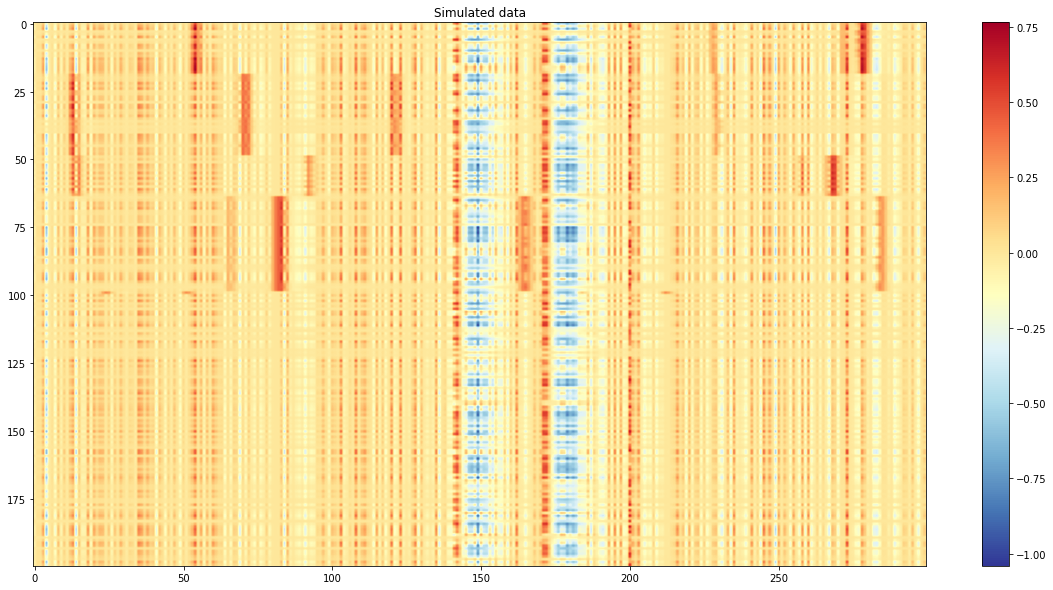

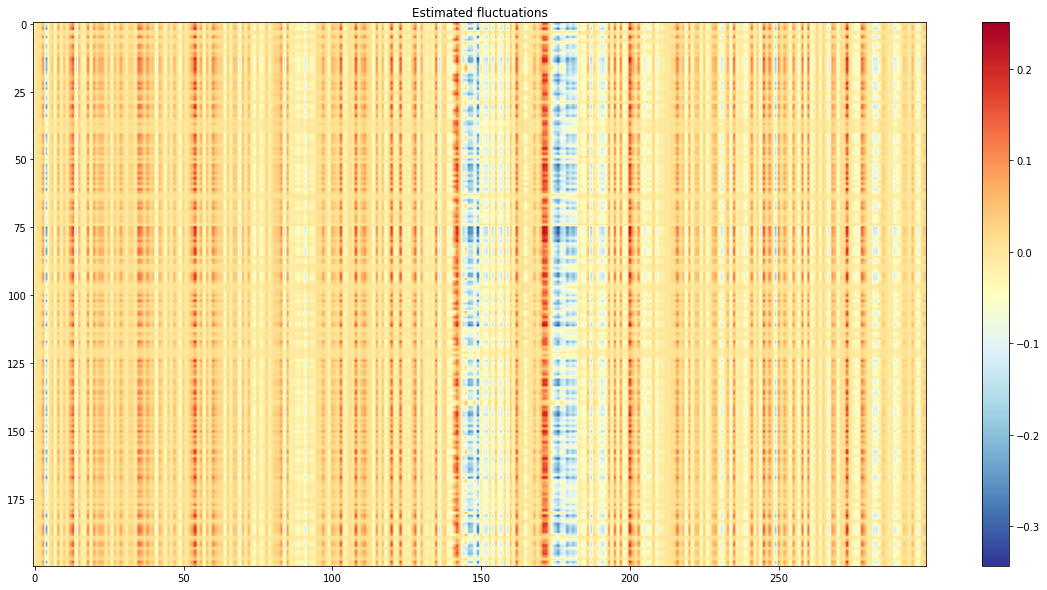

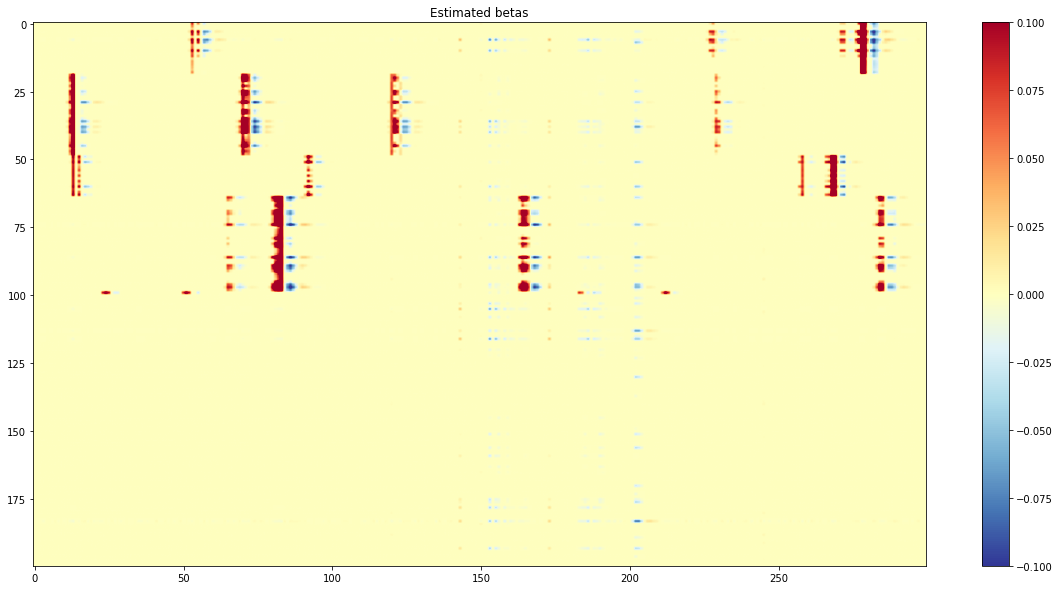

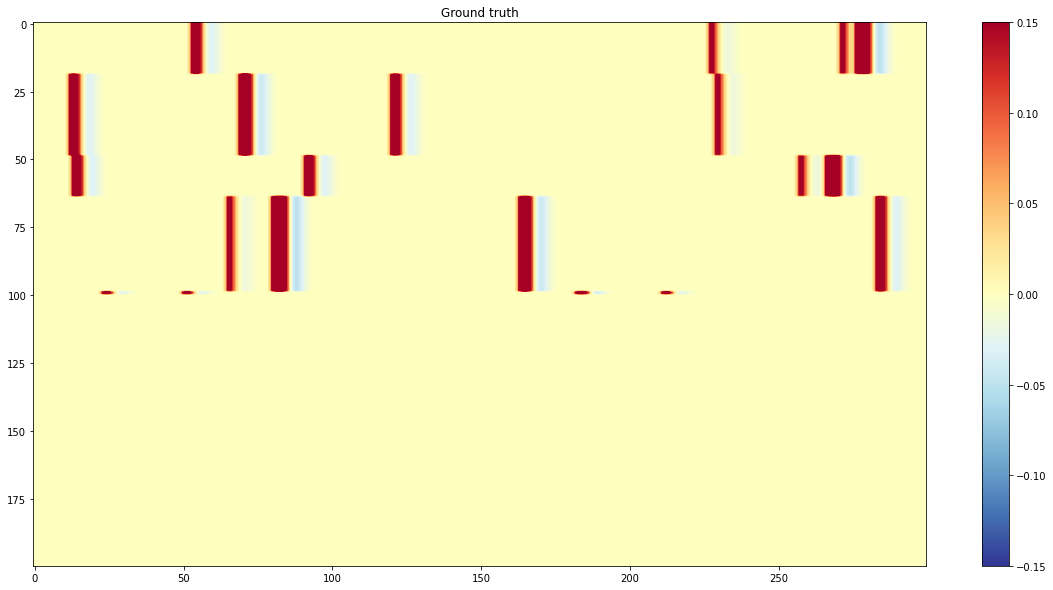

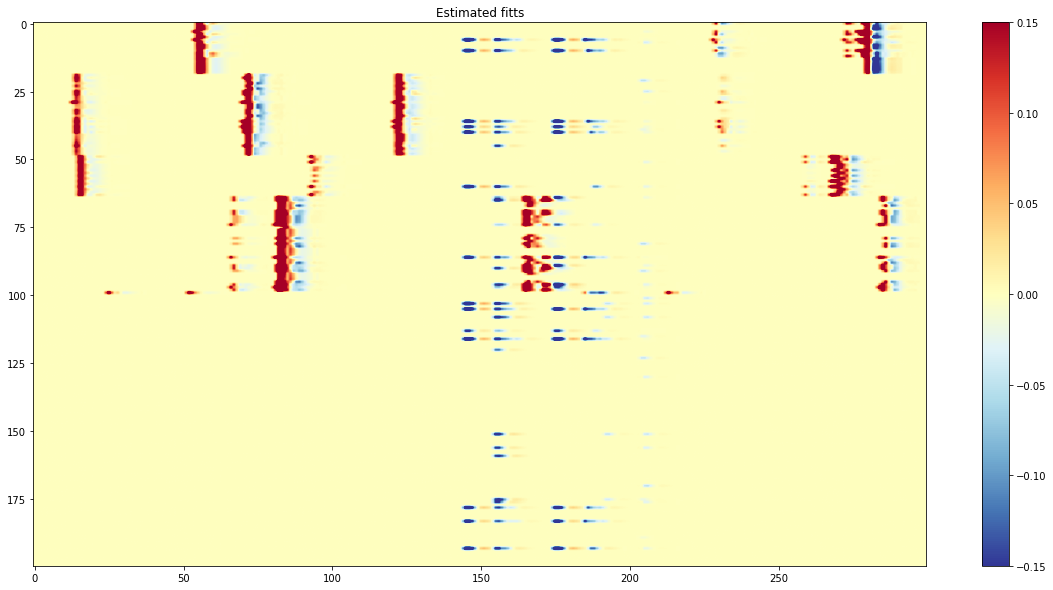

In [20]:
plt.figure(figsize=(20,10))
plt.imshow(data_200.T, cmap=cm.RdYlBu_r, aspect='auto')
plt.colorbar()
plt.title('Simulated data')

plt.figure(figsize=(20,10))
plt.imshow(L_200.T, cmap=cm.RdYlBu_r, aspect='auto')
plt.colorbar()
plt.title('Estimated fluctuations')

plt.figure(figsize=(20,10))
plt.imshow(S_200.T, cmap=cm.RdYlBu_r, aspect='auto', vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.title('Estimated betas')

plt.figure(figsize=(20,10))
plt.imshow(ground_truth_200.T, cmap=cm.RdYlBu_r, aspect='auto', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.title('Ground truth')

plt.figure(figsize=(20,10))
plt.imshow(S_fitts_200.T, cmap=cm.RdYlBu_r, aspect='auto', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.title('Estimated fitts')

## Testing with 500 voxels (400 with only low-rank)

In [21]:
%%capture
data_400 = data[:, :400]
ground_truth_400 = ground_truth[:, :400]
hrf_obj = HRFMatrix(TR=sim.tr, nscans=int(data_400.shape[0]), TE=sim.te, has_integrator=False)
hrf_norm = hrf_obj.generate_hrf().X_hrf_norm

L_400, S_400 = low_rank(data=data_400, hrf=hrf_norm)

In [24]:
S_deb_400, S_fitts_400 = debiasing(x=hrf_norm, y=data_400, beta=S_400, thr=1e-1)

Debiasing results...
Debiasing completed.


## Plot results with 500 voxels

Text(0.5, 1.0, 'Estimated fitts')

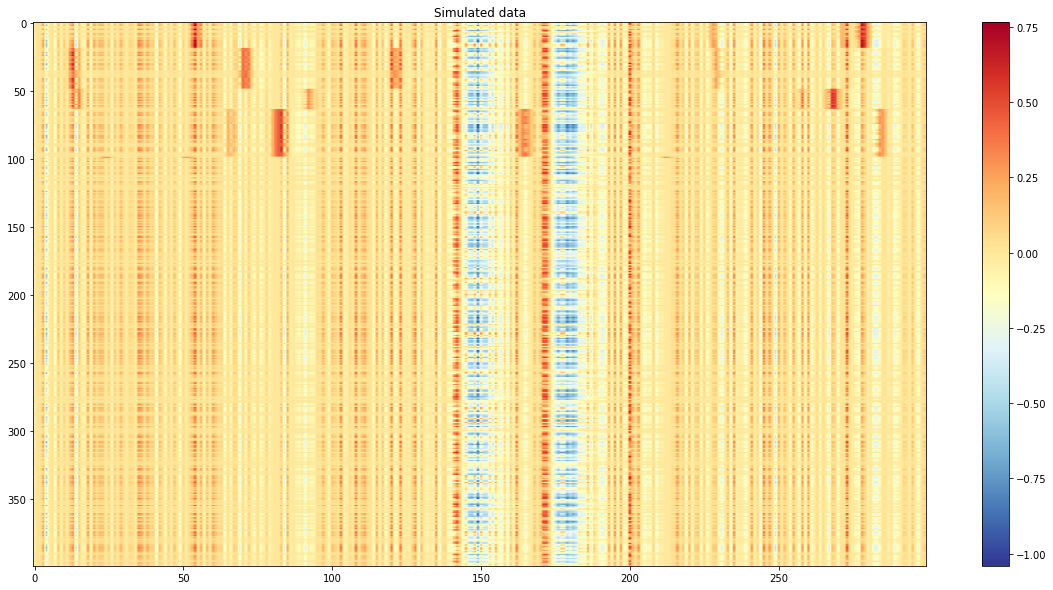

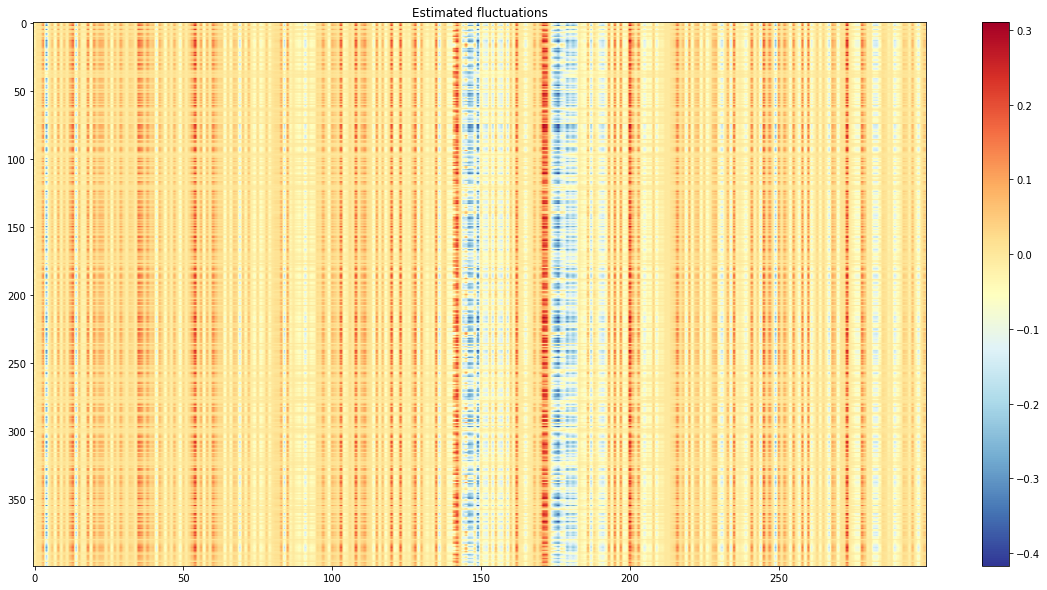

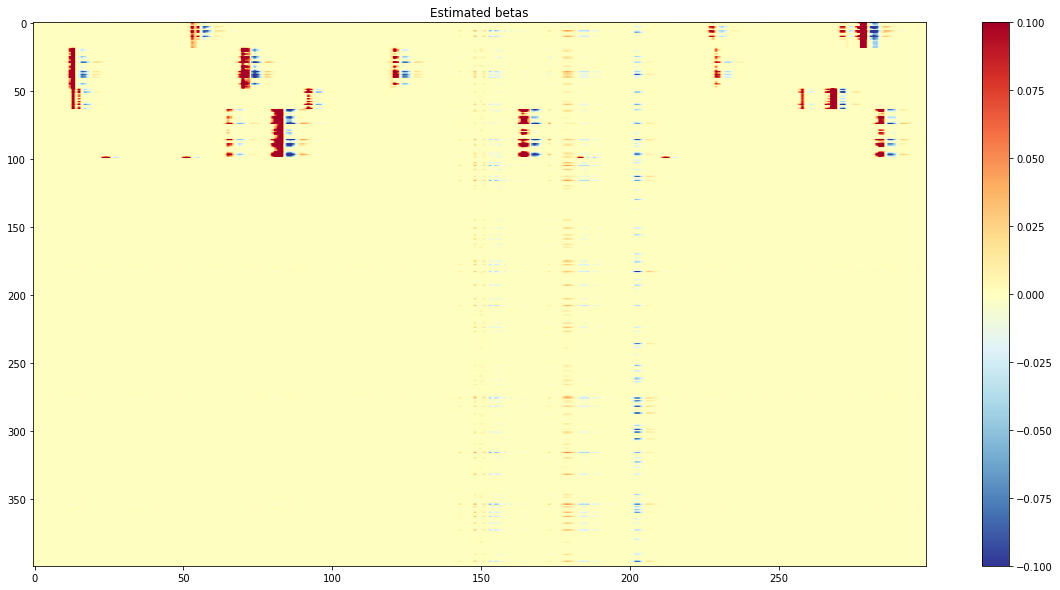

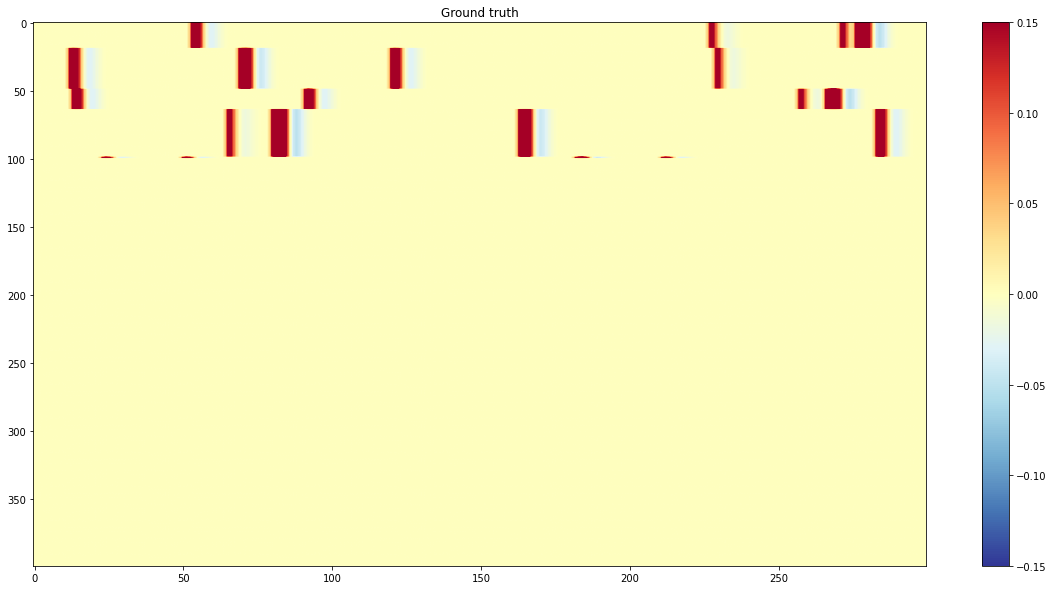

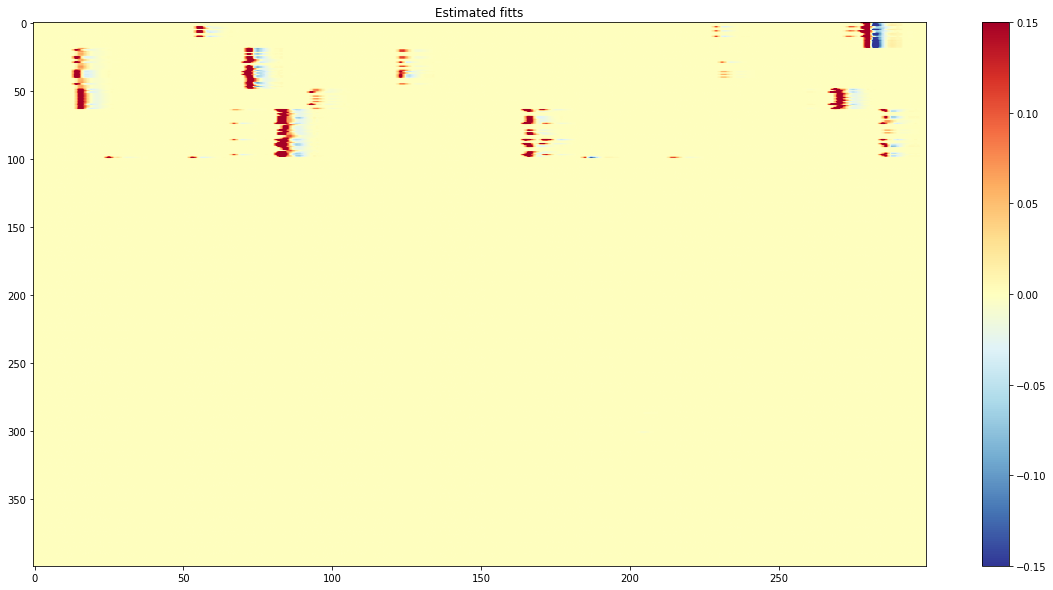

In [25]:
plt.figure(figsize=(20,10))
plt.imshow(data_400.T, cmap=cm.RdYlBu_r, aspect='auto')
plt.colorbar()
plt.title('Simulated data')

plt.figure(figsize=(20,10))
plt.imshow(L_400.T, cmap=cm.RdYlBu_r, aspect='auto')
plt.colorbar()
plt.title('Estimated fluctuations')

plt.figure(figsize=(20,10))
plt.imshow(S_400.T, cmap=cm.RdYlBu_r, aspect='auto', vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.title('Estimated betas')

plt.figure(figsize=(20,10))
plt.imshow(ground_truth_400.T, cmap=cm.RdYlBu_r, aspect='auto', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.title('Ground truth')

plt.figure(figsize=(20,10))
plt.imshow(S_fitts_400.T, cmap=cm.RdYlBu_r, aspect='auto', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.title('Estimated fitts')

## Try with integration operator

In [23]:
%%capture
hrf_obj = HRFMatrix(TR=sim.tr, nscans=int(data.shape[0]), TE=sim.te, has_integrator=True)
hrf_norm = hrf_obj.generate_hrf().X_hrf_norm

L_int, S_int = low_rank(data=data, hrf=hrf_norm)

Text(0.5, 1.0, 'Ground truth')

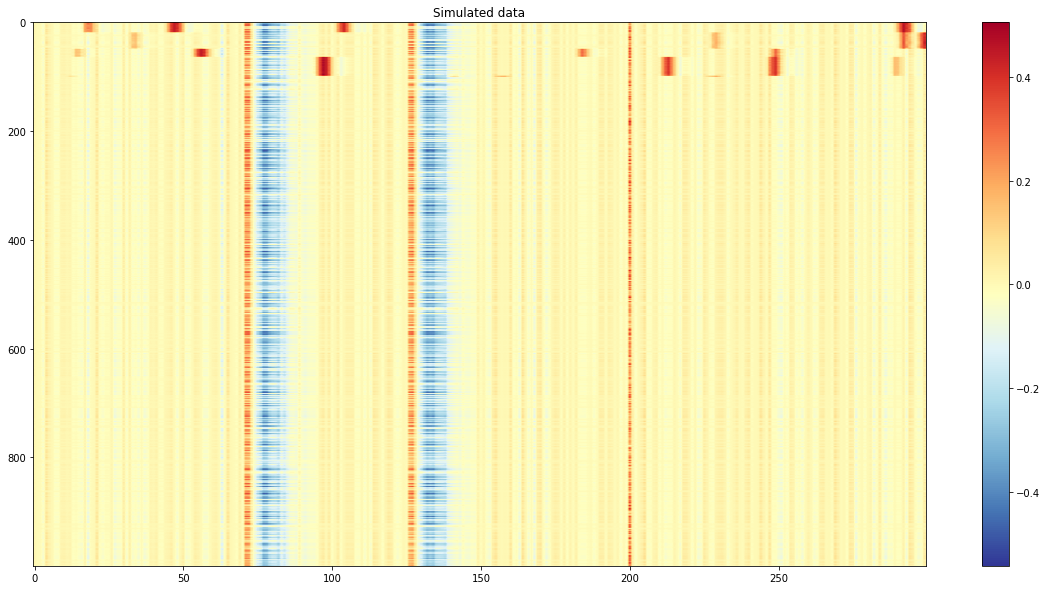

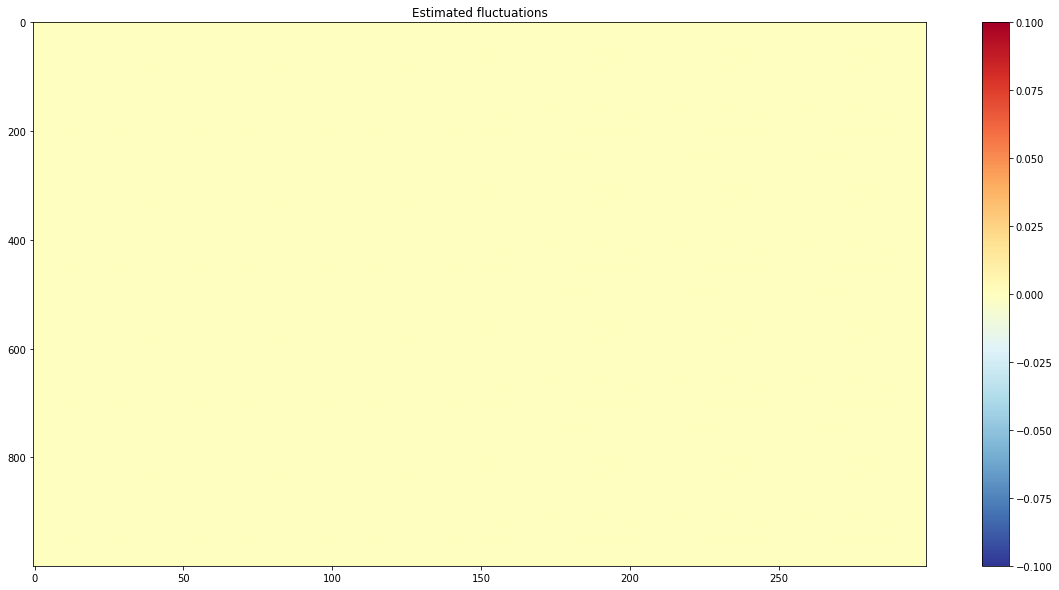

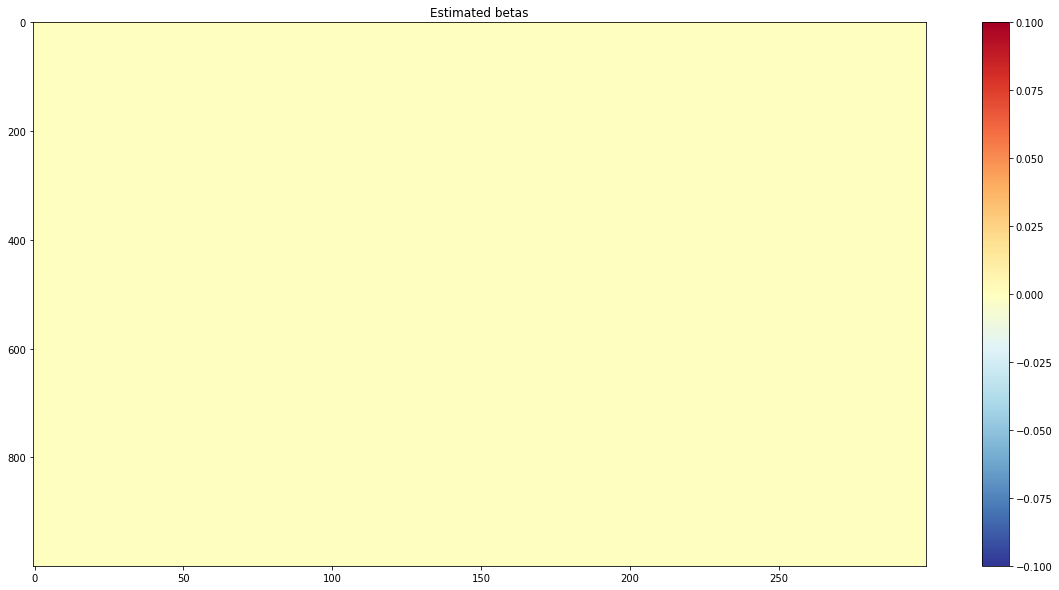

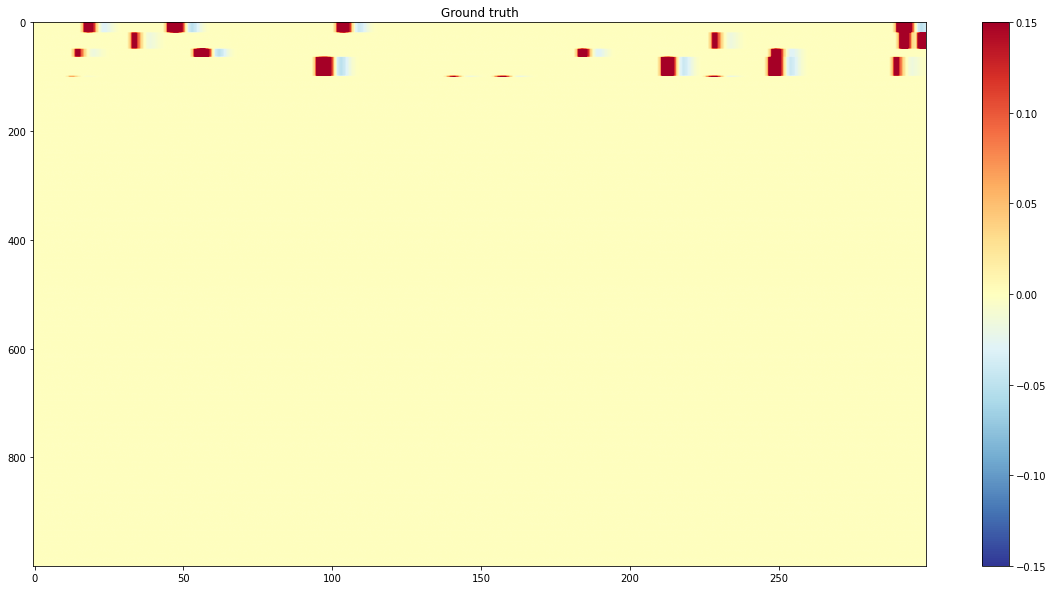

In [24]:
plt.figure(figsize=(20,10))
plt.imshow(data.T, cmap=cm.RdYlBu_r, aspect='auto')
plt.colorbar()
plt.title('Simulated data')

plt.figure(figsize=(20,10))
plt.imshow(L_int.T, cmap=cm.RdYlBu_r, aspect='auto')
plt.colorbar()
plt.title('Estimated fluctuations')

plt.figure(figsize=(20,10))
plt.imshow(S_int.T, cmap=cm.RdYlBu_r, aspect='auto', vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.title('Estimated betas')

plt.figure(figsize=(20,10))
plt.imshow(ground_truth.T, cmap=cm.RdYlBu_r, aspect='auto', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.title('Ground truth')